In [41]:
import pandas as pd
import numpy as np
import pyBigWig
import multiprocessing
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from random import sample
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import json

In [4]:
from matplotlib import rcParams 
rcParams['pdf.fonttype'] = 42 # True font
rcParams['font.family'] =  "sans-serif" 
rcParams['font.sans-serif'] = "Liberation Sans"  # font Arial
rcParams['font.size'] =  8  
rcParams['grid.linewidth'] =  0.5 
rcParams['lines.color'] = 'b' 
rcParams['lines.linewidth'] = 1 
rcParams['lines.markersize'] = 3
rcParams['lines.markeredgewidth'] = 0 # set Marker with no edgelines
rcParams['axes.linewidth'] = 0.5
rcParams['axes.titlesize'] = 12
rcParams['axes.labelsize'] = 8
rcParams['xtick.labelsize'] = 8
rcParams['ytick.labelsize'] = 8
rcParams['legend.fontsize'] = 8
rcParams['legend.title_fontsize'] = 8

In [5]:
def bins(chunk):
    """把文件按bin计算"""
    
    chrom_dict = _group_dict(chunk)
    if __name__ == '__main__':
        with multiprocessing.Pool(processes=24) as pool:
            args_list = [(key, value) for key, value in chrom_dict.items()]
            result = pool.map(func_wrapper, args_list)
        bins = pd.concat(result)
    
    return bins

def func(key, value):
    
    ref = chrom_bed.loc[chrom_bed.chrom==key]
    ref = ref.reset_index(drop=True)
    index1 = np.searchsorted(ref['end'].values,  value['pos'].values)
    index1 = [(len(ref)-1) if i==len(ref) else i for i in index1]
    value['bin'] = ref.loc[index1]['end'].reset_index(drop=True)
    
    return value

def func_wrapper(args):
    """pass parameter"""
    return func(*args)

def _group_dict(df):
    """将文件按chrom划分为字典
    
    bins的辅助函数
    """
    
    chrom_dict = {}
    
    group = df.groupby(by='chrom')
    for chrom, df in group:
        chrom_dict[chrom] = df.reset_index(drop=True)
        
    return chrom_dict

In [6]:
def _chrom_file_make(Genome, split = 20000):
    """以1k为bin划分基因组
    
    read_chromsize的辅助函数
    """
    
    Split_Dict = {}
    for index, row in Genome.iterrows():
        list1 = list(range(0, row["size"] - split, split))
        list2 = list(range(split, row["size"], split))
        
        if list2[-1] != row["size"]:
            list1.append(list2[-1])
            list2.append(row["size"])
            
        df1 = pd.DataFrame(list1)
        df2 = pd.DataFrame(list2)
        df1.columns = ["start"]
        df2.columns = ["end"]
        df = pd.concat([df1, df2], axis = 1)
        df["chrom"] = row["chrom"]
        order = ["chrom", "start", "end"]
        df = df[order]

        Split_Dict[row["chrom"]] = df
        
    Df_list = []
    for chrom, gdf in Split_Dict.items():
        Df_list.append(gdf)
    Df = pd.concat(Df_list)
    Df = Df.sort_values(by = ["chrom", "start", "end"])
    Df = Df.reset_index(drop = True)
    
    return Df

def read_chromsize(file):
    """读取基因组文件"""
    name_list = ['chrom', 'size']
    
    chromsize_df = pd.read_table(file, header=None, names=name_list)
    chromsize_df = chromsize_df.loc[chromsize_df.chrom.isin(chr_list)]# 只选取常见24条染色体
    chromsize_df = chromsize_df.sort_values(by=['chrom'])
    chromsize_df = chromsize_df.reset_index(drop=True)
    
    chrom_bed = _chrom_file_make(chromsize_df)# 将基因组文件转换为bed文件
    
    return chrom_bed

In [7]:
def bin_df(file_path, namelist):
    """读取enh文件，并计算pos"""
    binfile_df = pd.read_csv(file_path, sep="\t", header=None,
                             names=name_list)
    binfile_df['pos'] = (binfile_df['start']+binfile_df['end']) / 2
    binfile_df = binfile_df.loc[binfile_df.chrom.isin(chr_list)]
    
    return binfile_df

In [8]:
def pro_enh_dict(bins_df):
    """Match pro to enh"""
    enh_name_len = len(bins_df)
    enh_name_list = [f"E{name_id}" for name_id in range(enh_name_len)]
    bins_df['Eid'] = enh_name_list
    
    bins_dict = {}
    bins_group = bins_df.groupby('targetgene')
    for target_gene, df in bins_group:
        keys = df['Eid']
        values = list(zip(df['chrom'] , df['bin']))
        # values.append(df['chrom'])
        # values.append(df['bin'])
        # values = [df['chrom'].values, df['bin'].values]
        eid_dict = {k: v for k, v in zip(keys, values)}
        bins_dict[target_gene] = eid_dict
    return bins_dict, bins_df

def pro_enh(pro_enh_dict):
    """Convert the enh corresponding to pro to a dataframe"""
    
    enh_dict = pro_enh_dict[select_gene['genename'].values[0]]
    enh_df = pd.DataFrame(enh_dict).T.drop_duplicates()
    enh_df = enh_df.rename(columns={0: 'chrom',
                                    1: 'pos'})
    return enh_df

In [9]:
def LoadMatrixReader(filename, sepstr="\t"):
    """"""
    
    file_reader = pd.read_table(filename, sep=sepstr,
                                header=None, names=['chrom', 'start', 
                                                    'end', 'read_id', 
                                                    'strand','fragment',
                                                    'acc', 'Msegment'],)
    return(file_reader)

In [10]:
def Bwmean(regions, bw):
    '''
    get mean values for regions from a bigwig file
    '''
    means = []
    chrom_lengths =  bw.chroms()
    for i, r in regions.iterrows() :
        chrom, start, end = r["chrom"], r["bin_start"], r["bin"]
        if end >= chrom_lengths[chrom]:
            end = chrom_lengths[chrom]
        mv = bw.stats(chrom, start, end, 'mean')[0]
        means.append(mv)
    return(means)

def Bwmean_real(regions, bw):
    '''
    get mean values for regions from a bigwig file
    '''
    means = []
    chrom_lengths =  bw.chroms()
    for i, r in regions.iterrows() :
        chrom, start, end = r["chrom"], r["start"], r["end"]
        if end >= chrom_lengths[chrom]:
            end = chrom_lengths[chrom]
        mv = bw.stats(chrom, start, end, 'mean')[0]
        means.append(mv)
    return(means)

def Palette( value, lut = 200, minvalue=0, maxvalue=0.3 ):
    '''
    name : colormap
    lut : interger, the number of colors in colormap
    value, minvalue, maxvalue
    '''
    cmap = "bwr"
    val_idx = np.searchsorted( np.linspace(minvalue, maxvalue, lut), value )
    color_val = plt.get_cmap(cmap, lut)(val_idx)
    return color_val

In [11]:
K_binfile = "/data1/LLR/GpC/figure5/process/K562.enh_38_sorted.txt"
G_binfile = "/data1/LLR/GpC/figure5/process/GM12878.enh_38_sorted.txt"
name_list = ['chrom', 'start', 'end', 'targetgene',
             'activity', 'hic_contact', 'ABC_Score']

chr_list = [
    "chr1", "chr2", "chr3", "chr4", "chr5", "chr6",
    "chr7", "chr8", "chr9", "chr10", "chr11", "chr12",
    "chr13", "chr14", "chr15", "chr16", "chr17", "chr18",
    "chr19", "chr20", "chr21", "chr22", "chrX", "chrY"
]
chromsize_path = "/data1/LLR/GpC/figure5/process/hg38.chrom.sizes"
chrom_bed = read_chromsize(chromsize_path)

In [12]:
%%time
G_data_path = "/data2/LLR/GpC/multienh/data/map_frag_methy/GM_paf_sorted.txt"
K_data_path = "/data2/LLR/GpC/multienh/data/map_frag_methy/K_paf_sorted.txt"

G_data = LoadMatrixReader(G_data_path)
K_data = LoadMatrixReader(K_data_path)

CPU times: user 43min 35s, sys: 20min 39s, total: 1h 4min 15s
Wall time: 1h 3min 25s


In [13]:
K_binfile_df = bin_df(K_binfile, name_list)
G_binfile_df = bin_df(G_binfile, name_list)

K_bins = bins(K_binfile_df)
G_bins = bins(G_binfile_df)

In [14]:
TSS = pd.read_table("/data1/LLR/GpC/figure5/process/Gene_summery.txt",
                    header=None, usecols=[0, 3, 4, 5, 6],
                    names=['chrom', 'start', 'end', 'strand', 'genename'])
TSS['pos'] = (TSS['start']+TSS['end']) / 2
TSS = bins(TSS)

In [15]:
TSS_gene_list = TSS['genename'].tolist()
K_bins = K_bins.loc[K_bins.targetgene.isin(TSS_gene_list)]
G_bins = G_bins.loc[G_bins.targetgene.isin(TSS_gene_list)]

In [16]:
K_pro_enh_dict, K_enh_total = pro_enh_dict(K_bins.copy())
G_pro_enh_dict, G_enh_total = pro_enh_dict(G_bins.copy())

for gene in TSS['genename'].tolist():
    if gene not in K_pro_enh_dict:
        K_pro_enh_dict[gene] = {}
        
for gene in TSS['genename'].tolist():
    if gene not in G_pro_enh_dict:
        G_pro_enh_dict[gene] = {}
        
dict_list = (G_pro_enh_dict, K_pro_enh_dict)

In [17]:
TSS.loc[TSS.genename=='PIM2']

,chrom,start,end,strand,genename,pos,bin
253,chrX,48913182,48919024,-,PIM2,48916103.0,48920000


In [18]:
K_bins

,chrom,start,end,targetgene,activity,hic_contact,ABC_Score,pos,bin
0,chr1,825725,826225,LINC00115,0.4029,1,0.0259,825975.0,840000
1,chr1,825725,826225,LINC01128,0.4029,1,0.0259,825975.0,840000
2,chr1,1001705,1002245,HES4,2.2156,1,0.0441,1001975.0,1020000
3,chr1,1001705,1002245,ISG15,2.2156,5,0.0273,1001975.0,1020000
4,chr1,1001705,1002245,LINC00115,2.2156,1,0.0235,1001975.0,1020000
...,...,...,...,...,...,...,...,...,...
1370,chrX,155069890,155070390,BRCC3,1.2219,1,0.0384,155070140.0,155080000
1371,chrX,155069890,155070390,CMC4,1.2219,1,0.0384,155070140.0,155080000
1372,chrX,155069890,155070390,MTCP1,1.2219,1,0.0384,155070140.0,155080000
1373,chrX,155218808,155219308,VBP1,2.4732,6,0.0426,155219058.0,155220000


In [19]:
UP_json_path = '/data1/LLR/GpC/figure5/process/GUP_PIVOT.json'
DOWN_json_path = '/data1/LLR/GpC/figure5/process/GDOWN_PIVOT.json'  # 您想要保存的文件路径和名称
G_specific = pd.read_json(UP_json_path, orient='records', lines=True)
K_specific = pd.read_json(DOWN_json_path, orient='records', lines=True)
G_stat = pd.read_table("/data1/LLR/GpC/figure5/process/G_stat_20k.txt",
                       header=None)
K_stat = pd.read_table("/data1/LLR/GpC/figure5/process/K_stat_20k.txt",
                       header=None)

In [20]:
#MIR155HG

In [42]:
K_specific.loc[K_specific['gene']=='HBG1']

,gene,G_enh_rat,K_enh_rat,G_RNAval,K_RNAval,G_ME_rat,G_SE_rat,K_ME_rat,K_SE_rat,G_express_type,...,K_GCmean,G_ME_type,K_ME_type,G_log,K_log,index,logFC,P.Value,G_multi_intensity,K_multi_intensity
298,HBG1,0.0,0.323471,0.7125,9252.5125,0.0,0.0,0.038462,0.245562,low\n10709,...,0.446394,other\n12305,ME\n5385,0.233631,3.966307,HBG1,-12.47997,8.400000e-09,1,3


In [43]:
select_gene = TSS.loc[TSS.genename=='HBG1'].copy()# MIR155HG, HBA2
select_gene['bin_start'] = select_gene['bin']-20000

G_enh_df = pro_enh(G_pro_enh_dict)
K_enh_df = pro_enh(K_pro_enh_dict)
if not G_enh_df.empty:
    G_enh_df = G_enh_df.loc[G_enh_df['pos']!=select_gene['bin'].values[0]]
if not K_enh_df.empty:
    K_enh_df = K_enh_df.loc[K_enh_df['pos']!=select_gene['bin'].values[0]]

In [44]:
select_gene

,chrom,start,end,strand,genename,pos,bin,bin_start
148,chr11,5248079,5249859,-,HBG1,5248969.0,5260000,5240000


In [45]:
G_pro_enh_dict[select_gene['genename'].values[0]]

{}

In [46]:
TSS.loc[TSS.genename==select_gene['genename'].values[0], 'bin']

148    5260000
Name: bin, dtype: int64

In [47]:
G_select_reads = G_stat.loc[G_stat[1]==select_gene['genename'].values[0], 0].tolist()
K_select_reads = K_stat.loc[K_stat[1]==select_gene['genename'].values[0], 0].tolist()

In [48]:
print(len(G_select_reads), len(K_select_reads))

1030 1014


In [49]:
def read_dict(df):
    """group by read and store by dictionary"""
    
    df = df.copy()
    dictionary = {}
    group = df.groupby("read_id")
    for rid, df in group:
        df = df.sort_values(by=['acc'], ascending=False)
        df = df.drop_duplicates(subset=['chrom', 'bin', 'read_id'])
        dictionary[rid] = df.reset_index(drop=True)
        
    return dictionary

def read_sorted(Dict):
    """Sort reads according to the first fragment"""
    
    sort_dict = {}
    for readid, df in Dict.items():
        tmp_list = []
        tmp_list.append(min(df["bin_start"]))
        # tmp_list.append(df.iloc[0, 14])
        sort_dict[readid] = min(tmp_list)
    sort_list = sorted(sort_dict.items(), key = lambda kv:(kv[1], kv[0]))
    return sort_list

In [50]:
#reads select
G_select_data = G_data.loc[G_data.read_id.isin(G_select_reads)].copy()
K_select_data = K_data.loc[K_data.read_id.isin(K_select_reads)].copy()

#chrom select
G_select_data = G_select_data.loc[G_select_data.chrom==select_gene.iloc[0]['chrom']].copy()
K_select_data = K_select_data.loc[K_select_data.chrom==select_gene.iloc[0]['chrom']].copy()

G_select_data['pos'] = (G_select_data['start']+G_select_data['end']) / 2
K_select_data['pos'] = (K_select_data['start']+K_select_data['end']) / 2

G_bins = bins(G_select_data)
K_bins = bins(K_select_data)
G_bins['bin_start'] = G_bins['bin'] - 20000
K_bins['bin_start'] = K_bins['bin'] - 20000

In [51]:
## bigwig file
bigdir = "/data1/LLR/GpC/figure5/process"
# CpG_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_CpG.bigWig") # Open bigWig file
# k562_CpG_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_CpG.bigWig") # Open bigWig file

GpC_bw = pyBigWig.open(f"{bigdir}/GM12878_Integrated_GpC.bigWig") # Open bigWig file
k562_GpC_bw = pyBigWig.open(f"{bigdir}/K562_Integrated_GpC.bigWig") # Open bigWig file

In [52]:
G_bins["gm_GpC"] = Bwmean(G_bins, GpC_bw)
K_bins["k_GpC"] = Bwmean(K_bins, k562_GpC_bw)

G_bins["gm_GpC_real"] = Bwmean_real(G_bins, GpC_bw)
K_bins["k_GpC_real"] = Bwmean_real(K_bins, k562_GpC_bw)

select_gene["gm_GpC_real"] = Bwmean_real(select_gene, GpC_bw)
select_gene["k_GpC_real"] = Bwmean_real(select_gene, k562_GpC_bw)

select_gene["gm_GpC"] = Bwmean(select_gene, GpC_bw)
select_gene["k_GpC"] = Bwmean(select_gene, k562_GpC_bw)

G_bins['gene_pos'] = TSS.loc[TSS.genename==select_gene['genename'].values[0], 'bin'].values[0]
K_bins['gene_pos'] = TSS.loc[TSS.genename==select_gene['genename'].values[0], 'bin'].values[0]

G_dict = read_dict(G_bins)
K_dict = read_dict(K_bins)

G_sort_list = read_sorted(G_dict)
K_sort_list = read_sorted(K_dict)



In [53]:
def high_order_plot(sort_list, data_dict, flag, title='title', save=False, filename="high_order.pdf", color_range=0.2):
    """"""
    
    # reads that passed enh were counted
    N_list = []
    FLANK = 200000
    sample_number = 10
    for i in sort_list:
        plot_data = data_dict[i[0]]

        for index, row in plot_data.iterrows():
            if K_enh_df.empty:
#                 #| (row['bin']==row['gene_pos']))
                if ((row['bin'] in G_enh_df['pos'].tolist())):
                    N_list.append(row['read_id'])
                    
            elif G_enh_df.empty:
                if ((row['bin'] in K_enh_df['pos'].tolist())):
                    N_list.append(row['read_id'])
                    
            else:
                if ((row['bin'] in K_enh_df['pos'].tolist()) | (row['bin'] in G_enh_df['pos'].tolist())):
                    P = Palette(row[gpc_list[flag-1]])
                    axes[flag].plot([row['bin_start'], row['bin']], [row['read_id'], row['read_id']], color=P,
                                    linestyle='-', linewidth=2)
                    
                    N_list.append(row['read_id'])

    select_gene_pos = row['gene_pos']
        # axes[flag].plot([select_gene_pos-20000, select_gene_pos], ['top', 'top'], color='black',
        #          linestyle='-', linewidth=2)

    # colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=color_range)
    sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm) 
    divider0 = make_axes_locatable(axes[flag])
    cax = divider0.append_axes("right", size="1.5%", pad=0.1, aspect=6)
    axes[flag].tick_params(labelleft=False, left=False)
    fig.colorbar(sm, cax=cax)
    print(len(N_list))
    # GM12878
    if flag == 1:
        axes[flag].set_ylabel(f"GM12878\n{len(G_sort_list)}(sample {sample_number})")
        plot_list = sample(N_list, sample_number)
        for rid in set(plot_list):
            tmp_list = []
            for index, row in data_dict[rid].iterrows():
                if G_enh_df.empty:
                    if ((row['bin'] in K_enh_df['pos'].tolist())):
                        tmp_list.append(row['bin'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['bin_start'], row['bin']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 
                else:
                    if ((row['bin'] in G_enh_df['pos'].tolist())):
                        tmp_list.append(row['bin'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['bin_start'], row['bin']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 
                        
            tmp_list = [i-20000 for i in tmp_list] + tmp_list
            P = Palette(select_gene[gpc_list[flag-1]], maxvalue=color_range)
            axes[flag].plot([select_gene['bin_start'], select_gene['bin']], [rid, rid], color=P, linewidth=6)
            tmp_list.append(select_gene['bin_start'].values[0])
            tmp_list.append(select_gene['bin'].values[0])
            axes[flag].plot([min(tmp_list), max(tmp_list)], [rid, rid], color='silver', linewidth=1, zorder=1)
            axes[flag].tick_params(bottom=False)
    
    # K562
    if flag == 2:
        axes[flag].set_ylabel(f"K562\n{len(sort_list)}(sample {sample_number})")
        plot_list = sample(N_list, sample_number)
        for rid in set(plot_list):
            tmp_list = []
            for index, row in data_dict[rid].iterrows():
                if G_enh_df.empty:
                    if ((row['bin'] in K_enh_df['pos'].tolist())):
                        tmp_list.append(row['bin'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['bin_start'], row['bin']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6)
                else:
                    if ((row['bin'] in G_enh_df['pos'].tolist())):
                        tmp_list.append(row['bin'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['bin_start'], row['bin']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 
            tmp_list = [i-20000 for i in tmp_list] + tmp_list
            P = Palette(select_gene[gpc_list[flag-1]], maxvalue=color_range)
            axes[flag].plot([select_gene['bin_start'], select_gene['bin']], [rid, rid], color=P, linewidth=6)
            tmp_list.append(select_gene['bin_start'].values[0])
            tmp_list.append(select_gene['bin'].values[0])
            axes[flag].plot([min(tmp_list), max(tmp_list)], [rid, rid], color='silver', linewidth=1, zorder=1)
        axes[0].set_title(title)
        if save:
            plt.savefig(filename)
        plt.show()

In [54]:
def high_order_plot_v1(sort_list, data_dict, flag, title='title', save=False, filename="high_order.pdf", color_range=0.2):
    """"""
    
    # reads that passed enh were counted
    N_list = []
    FLANK = 2000
    sample_number = 10
    for i in sort_list:
        plot_data = data_dict[i[0]]

        for index, row in plot_data.iterrows():
            if K_enh_df.empty:
                if ((row['bin'] in G_enh_df['pos'].tolist())):
                    N_list.append(row['read_id'])
                    
            elif G_enh_df.empty:
                if ((row['bin'] in K_enh_df['pos'].tolist())):
                    N_list.append(row['read_id'])
                    
            else:
                if ((row['bin'] in K_enh_df['pos'].tolist()) | (row['bin'] in G_enh_df['pos'].tolist())):
                    N_list.append(row['read_id'])

    select_gene_pos = row['gene_pos']

    # colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=color_range)
    sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm) 
    divider0 = make_axes_locatable(axes[flag])
    cax = divider0.append_axes("right", size="2.5%", pad=0.1, aspect=6)
    axes[flag].tick_params(labelleft=False, left=False)
    fig.colorbar(sm, cax=cax)
    # GM12878
    if flag == 1:
        axes[flag].set_ylabel(f"GM12878\n{len(G_sort_list)}(sample {sample_number})")
        plot_list = sample(N_list, sample_number)
        for rid in set(plot_list):
            tmp_list = []
            for index, row in data_dict[rid].iterrows():
                if G_enh_df.empty:
                    if ((row['bin'] in K_enh_df['pos'].tolist())) | ((row['bin'] in select_gene['bin'].tolist())):
                        tmp_list.append(row['start'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['start'], row['end']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 
                else:
                    if ((row['bin'] in G_enh_df['pos'].tolist())) | ((row['bin'] in select_gene['bin'].tolist())):
                        tmp_list.append(row['start'])
                        P = Palette(row[gpc_list[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['start'], row['end']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 

            axes[flag].plot([min(tmp_list), max(tmp_list)], [rid, rid], color='silver', linewidth=1, zorder=1)
            axes[flag].tick_params(bottom=False)
    
    # K562
    if flag == 2:
        axes[flag].set_ylabel(f"K562\n{len(sort_list)}(show {sample_number})")
        plot_list = sample(N_list, sample_number)
        for rid in set(plot_list):
            tmp_list = []
            for index, row in data_dict[rid].iterrows():
                if G_enh_df.empty:
                    if ((row['bin'] in K_enh_df['pos'].tolist())) | ((row['bin'] in select_gene['bin'].tolist())):
                        tmp_list.append(row['start'])
                        P = Palette(row[gpc_list_real[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['start'], row['end']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6)
                else:
                    if ((row['bin'] in G_enh_df['pos'].tolist())) | ((row['bin'] in select_gene['bin'].tolist())):
                        tmp_list.append(row['start'])
                        P = Palette(row[gpc_list_real[flag-1]], maxvalue=color_range)
                        axes[flag].plot([row['start'], row['end']], [row['read_id'], row['read_id']], color=P,
                                        linestyle='-', linewidth=6) 

            axes[flag].plot([min(tmp_list), max(tmp_list)], [rid, rid], color='silver', linewidth=1, zorder=1)
        axes[0].set_title(title)
        if (G_enh_df.empty) & (not K_enh_df.empty):
            tmp_list = []
            tmp_list = K_enh_df['pos'].tolist()
            tmp_list = [i-20000 for i in tmp_list] + tmp_list + select_gene['bin'].tolist()
            axes[flag].set_xlim(min(tmp_list)-FLANK, max(tmp_list)+FLANK)
            
        if (K_enh_df.empty) & (not G_enh_df.empty):
            tmp_list = []
            tmp_list = G_enh_df['pos'].tolist()
            tmp_list = [i-20000 for i in tmp_list] + tmp_list + select_gene['bin'].tolist()
            axes[flag].set_xlim(min(tmp_list)-FLANK, max(tmp_list)+FLANK)
            
        if (not G_enh_df.empty) & (not K_enh_df.empty):
            tmp_list = []
            tmp_list = K_enh_df['pos'].tolist()
            tmp_list = tmp_list + G_enh_df['pos'].tolist()
            tmp_list = [i-20000 for i in tmp_list] + tmp_list + select_gene['bin'].tolist()
            axes[flag].set_xlim(min(tmp_list)-FLANK, max(tmp_list)+FLANK)
        if save:
            plt.savefig(filename)
        plt.show()
    return plot_list

In [55]:
def enh_plot(G_enh, K_enh, color_range=1):
    """Gene element annotation"""
    
    #enh
    for index, row in G_enh.iterrows():
        st = row['start']
        width = row['end'] - row['start']
        G_rect = plt.Rectangle((st, 0),width,0.01, color='orange',)
        axes[0].add_patch(G_rect)
        # axes[0].text(st, 0.02, 'G',fontsize=8)
        
    for index, row in K_enh.iterrows():
        st = row['start']
        width = row['end'] - row['start']
        K_rect = plt.Rectangle((st, 0),width,0.01, color='cyan',)
        axes[0].add_patch(K_rect)
        # axes[0].text(st, 0.02, 'K',fontsize=8)
    
    #legend
    legend_elements = [Line2D([0], [0], color='black', lw=4, label='Pro'),
                   Line2D([0], [0], color='orange', lw=4, label='G_enh'),
                   Line2D([0], [0], color='cyan', lw=4, label='K_enh')]
    axes[0].legend(handles=legend_elements, loc='upper right')
    
    #Pro
    axes[0].plot([(select_gene['start'].values[0]), select_gene['end'].values[0]], [0, 0], color='black',
                 linestyle='-', linewidth=4)
    text_str = select_gene['genename'].values[0]
    text_loc = (select_gene['start'].values[0]+select_gene['end'].values[0])//2
    axes[0].text(text_loc, 0.01, f'{text_str}',fontsize=8,
                 horizontalalignment='center')
    
    #colorbar
    norm = mpl.colors.Normalize(vmin=0, vmax=color_range)
    sm = plt.cm.ScalarMappable(cmap="bwr", norm=norm) 
    divider0 = make_axes_locatable(axes[0])
    cax = divider0.append_axes("right", size="2.5%", pad=0.1, aspect=6)
    axes[0].tick_params(labelleft=False, left=False, bottom=False)
    fig.colorbar(sm, cax=cax)
    
    axes[0].set_ylim(-0.025, 0.05)
    

In [56]:
gpc_list = ["gm_GpC", "k_GpC"]
gpc_list_real = ["gm_GpC_real", "k_GpC_real"]
G_enh_pos_real = G_enh_total.loc[G_enh_total['Eid'].isin(G_enh_df.index)]
K_enh_pos_real = K_enh_total.loc[K_enh_total['Eid'].isin(K_enh_df.index)]

In [57]:
OUT_DIR = '/data1/LLR/GpC/figure5/process'

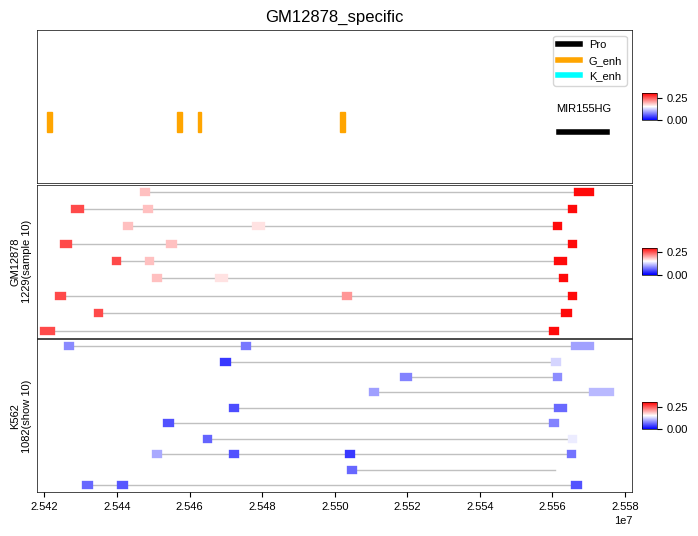

In [337]:
fig, axes = plt.subplots(nrows=3,ncols=1,
                       figsize = (8, 6), sharex=True)
plt.subplots_adjust(hspace=0.01)
color_range=0.3
enh_plot(G_enh_pos_real, K_enh_pos_real, color_range=color_range)
G_plotlist = high_order_plot_v1(G_sort_list, G_dict, 1, color_range=color_range)
K_plotlist = high_order_plot_v1(K_sort_list, K_dict, 2, "GM12878_specific", color_range=color_range,
                             save=False, filename="")

# a = json.dumps(K_plotlist)
# f1 = open(f'{OUT_DIR}/GMspe_Kreal_plot.json', 'w')
# f1.write(a)
# f1.close()

# b = json.dumps(G_plotlist)
# f2 = open(f'{OUT_DIR}/GMspe_Greal_plot.json', 'w')
# f2.write(b)
# f2.close()

In [85]:
K_enh_df

,chrom,pos
E11467,chr16,120000
E11491,chr16,140000
E11499,chr16,160000
E11523,chr16,200000


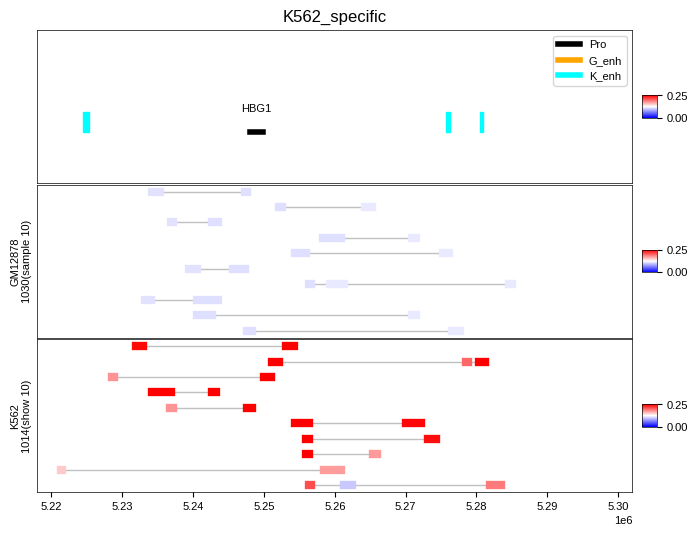

In [83]:
fig, axes = plt.subplots(nrows=3,ncols=1,
                       figsize = (8, 6), sharex=True)
plt.subplots_adjust(hspace=0.01)
color_range=0.25
enh_plot(G_enh_pos_real, K_enh_pos_real, color_range=color_range)
G_plotlist = high_order_plot_v1(G_sort_list, G_dict, 1, color_range=color_range)
K_plotlist = high_order_plot_v1(K_sort_list, K_dict, 2, "K562_specific", color_range=color_range, save=True, filename="/data1/LLR/GpC/figure5/diff/figure/K_spe_sample.pdf")

a = json.dumps(K_plotlist)
f1 = open(f'{OUT_DIR}/Kspe_Kreal_plot.json', 'w')
f1.write(a)
f1.close()

b = json.dumps(G_plotlist)
f2 = open(f'{OUT_DIR}/Kspe_Greal_plot.json', 'w')
f2.write(b)
f2.close()